In [1]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2

# Dataset functions

In [2]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [3]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [233]:
def visualize_multiple_rows(*image_lists, names = None):
    n = len(image_lists)
    m = len(image_lists[0])

    fig, axes = plt.subplots(m, n, figsize=(12, 60))  # 15 rows, 3 columns
    
    for i, image_list in enumerate(image_lists):
        for j, image in enumerate(image_list):

            axes[j, i].imshow(image)
            axes[j, i].axis("off")
            
            # plt.subplot(m, n, i + j + 1)
            # plt.xticks([])
            # plt.yticks([])
            # if names is not None:
            #     plt.title(' '.join(names[j]))
            # plt.imshow(image)
    plt.show()

In [4]:
masks_df = pd.read_csv('datasets/airbus-ship-detection/train_ship_segmentations_v2.csv')

For this notebook to work properly unzip the dataset under **datasets** directory

# Creating model with tensorflow

## Working with dataset

In [5]:
masks_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Masks are encoded, images are saved separately

In [6]:
side_size = 128 # size of input and output layers of model

### Loading and decoding data into a numpy array

In [7]:
import cv2

def resize_mask(row):  # decodes and resizes masks to side_size by side_size
    
    if row["EncodedPixels"] is np.NaN:
        return np.zeros((side_size, side_size))
    
    mask = row["EncodedPixels"]
    
    np_seg = rle_decode(mask)

    return cv2.resize(np_seg, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

In [8]:
train_dir = "datasets/airbus-ship-detection/train_v2"
x_train_dir = f"{train_dir}"


def load_resize_image(row): # loads images into the dataframe
    image = cv2.imread(os.path.join(x_train_dir, row["ImageId"]))
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

    return image

It was decided to limit the amount of data model trains on to minimize time, due to hardware constrains

In [9]:
masks_df_slice = masks_df.dropna()[:40005]
masks_df_slice

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
112893,7c7b9d696.jpg,175494 9 176262 9 177030 9 177798 9 178566 9 1...
112894,7c7b9d696.jpg,122479 22 123225 44 123993 44 124761 44 125529...
112895,7c7b9d696.jpg,432647 1 433414 3 434181 5 434948 7 435715 9 4...
112896,7c7b9d696.jpg,459922 21 460690 21 461458 21 462226 21 462994...


In [10]:
masks_df_slice["decoded_mask"] = masks_df_slice.apply(resize_mask, axis = 1)
masks_df_slice

,ImageId,EncodedPixels,decoded_mask
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
112893,7c7b9d696.jpg,175494 9 176262 9 177030 9 177798 9 178566 9 1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112894,7c7b9d696.jpg,122479 22 123225 44 123993 44 124761 44 125529...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112895,7c7b9d696.jpg,432647 1 433414 3 434181 5 434948 7 435715 9 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112896,7c7b9d696.jpg,459922 21 460690 21 461458 21 462226 21 462994...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
grouped = masks_df_slice.drop("EncodedPixels", axis = 1).groupby("ImageId").sum()
grouped

,decoded_mask
ImageId,
000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
7c7852de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7c792f1d9.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7c798bdf8.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [12]:
grouped = grouped.reset_index()
grouped

,ImageId,decoded_mask
0,000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
20727,7c7852de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20728,7c792f1d9.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20729,7c798bdf8.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20730,7c7a5fa63.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
grouped["gr_image"] = grouped.apply(load_resize_image, axis = 1)

Resulting 20732 photos that will be used in training

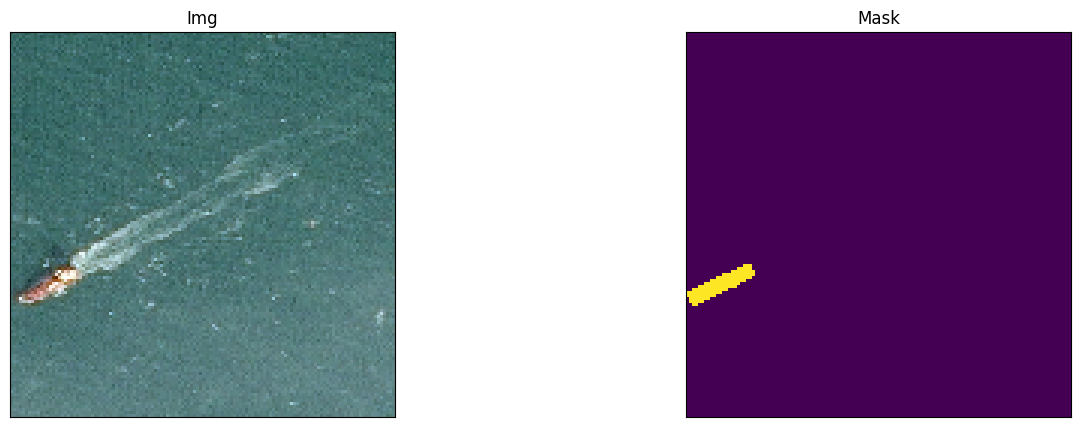

In [14]:
visualize(img = grouped.loc[745, "gr_image"], mask = grouped.loc[745, "decoded_mask"])  # demonstraiting a sample from dataset

In [15]:
grouped.to_csv("grouped_masked_loaded.csv")  # save formated dataset for future use

In [16]:
xy_train = grouped[["gr_image", "decoded_mask"]].sample(frac=0.8,random_state=200) # split dataset into train and test sets, split is 80/20
xy_test = grouped[["gr_image", "decoded_mask"]].drop(xy_train.index)

x_train = xy_train.drop("decoded_mask", axis = 1)
x_test= xy_test.drop("decoded_mask", axis = 1)

y_train = xy_train[["decoded_mask"]]
y_test= xy_test[["decoded_mask"]]

In [143]:
y_train_numpy = np.stack(y_train[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_train_numpy = y_train_numpy.reshape(*y_train_numpy.shape, 1) # transform it into 4d array for model compatability
y_train_numpy[y_train_numpy > 1] = 1 # due to the procces of merging all of the masks, some overlap, creating values above 1
y_train_numpy.shape

(16586, 128, 128, 1)

In [18]:
x_train_numpy = np.stack(x_train[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
x_train_numpy.shape

(16586, 128, 128, 3)

In [144]:
y_test_numpy = np.stack(y_test[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_test_numpy = y_test_numpy.reshape(*y_test_numpy.shape, 1) # transform it into 4d array for model compatability
y_test_numpy[y_test_numpy > 1] = 1 # due to the procces of merging all of the masks, some overlap, creating values above 1
y_test_numpy.shape

(4146, 128, 128, 1)

In [20]:
x_test_numpy = np.stack(x_test[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
x_test_numpy.shape

(4146, 128, 128, 3)

## Train the model

In [77]:
import tensorflow as tf
import keras

In [189]:
def get_model(img_sizem ,num_classes):
  """
  This function will define the U-net model
  """
  # define the input layer
  input_layer = keras.layers.Input(shape=img_sizem + (3, ))

  # Rescaling layer
  rescaling = keras.layers.Rescaling(1. / 255)(input_layer) # rescale input images to [0, 1]

  # define convolution layers (Downward)
  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu", strides=2)(rescaling)
  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu", strides=2)(x)
  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
  x = keras.layers.Dropout(0.01)(x)

  # define Transpose layers (Upward)
  y = keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu")(x)
  y = keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu", strides=2)(y)
  y = keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu")(y)
  y = keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu", strides=2)(y)
  y = keras.layers.Dropout(0.01)(y)

  # define the output layer
  output_layer = keras.layers.Conv2D(num_classes, 3, padding="same", activation="sigmoid")(y)

  # create the model
  model = keras.models.Model(input_layer, output_layer)

  return model

In [190]:
segmentation_model = get_model((side_size, side_size), 1)

In [191]:
segmentation_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_16 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_64                  │ (None, 32, 32, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_65                  │ (None, 64, 64, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_66                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_67                  │ (None, 128, 128, 64)        │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 128, 128, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,625 (2.54 MB)

 Trainable params: 666,625 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
# compile the model
segmentation_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[keras.metrics.BinaryIoU(), keras.metrics.BinaryAccuracy()])

In [193]:
callbacks = [keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)]

In [203]:
history = segmentation_model.fit(x_train_numpy, y_train_numpy, epochs=10, batch_size=32, validation_data=(x_test_numpy, y_test_numpy), callbacks=callbacks)

Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - binary_accuracy: 0.9963 - binary_io_u_15: 0.6823 - loss: 0.0119 - val_binary_accuracy: 0.9937 - val_binary_io_u_15: 0.6765 - val_loss: 0.0163
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - binary_accuracy: 0.9964 - binary_io_u_15: 0.7030 - loss: 0.0111 - val_binary_accuracy: 0.9966 - val_binary_io_u_15: 0.7305 - val_loss: 0.0104
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - binary_accuracy: 0.9966 - binary_io_u_15: 0.7199 - loss: 0.0102 - val_binary_accuracy: 0.9963 - val_binary_io_u_15: 0.7473 - val_loss: 0.0110
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - binary_accuracy: 0.9969 - binary_io_u_15: 0.7327 - loss: 0.0095 - val_binary_accuracy: 0.9970 - val_binary_io_u_15: 0.7685 - val_loss: 0.0088
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - binary_accuracy: 0.9969 - binary_io_u_15: 0.7406 - loss: 0.0090 - val_binary_accuracy: 0.9970 - val_binary_io_u_15: 0.7315 - val_loss: 0.0091
Epoch 6/10
519/

In [204]:
segmentation_model.save("segmentation_model_2.keras")

In [205]:
res = segmentation_model.evaluate(x_test_numpy, y_test_numpy)

130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - binary_accuracy: 0.9951 - binary_io_u_15: 0.7247 - loss: 0.0160


In [208]:
print(history.history)

{'binary_accuracy': [0.9962962865829468, 0.9965538382530212, 0.996691107749939, 0.9968821406364441, 0.9969893097877502, 0.9971181154251099, 0.9972019791603088, 0.9973358511924744, 0.997401237487793, 0.997493326663971], 'binary_io_u_15': [0.6866278648376465, 0.7088831663131714, 0.7208905220031738, 0.7360936403274536, 0.7445024251937866, 0.7543007135391235, 0.761042058467865, 0.7711092233657837, 0.7762029767036438, 0.7838983535766602], 'loss': [0.01173426304012537, 0.010674316436052322, 0.010047739371657372, 0.009365685284137726, 0.00894170068204403, 0.008508238941431046, 0.008199474774301052, 0.007788250222802162, 0.00758222583681345, 0.007256972603499889], 'val_binary_accuracy': [0.9937206506729126, 0.9966450333595276, 0.9963394403457642, 0.99703449010849, 0.9970154166221619, 0.9970278143882751, 0.9974123239517212, 0.9974788427352905, 0.9960218071937561, 0.9951485395431519], 'val_binary_io_u_15': [0.6765128374099731, 0.7304887771606445, 0.7472786903381348, 0.7685291767120361, 0.7315006

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


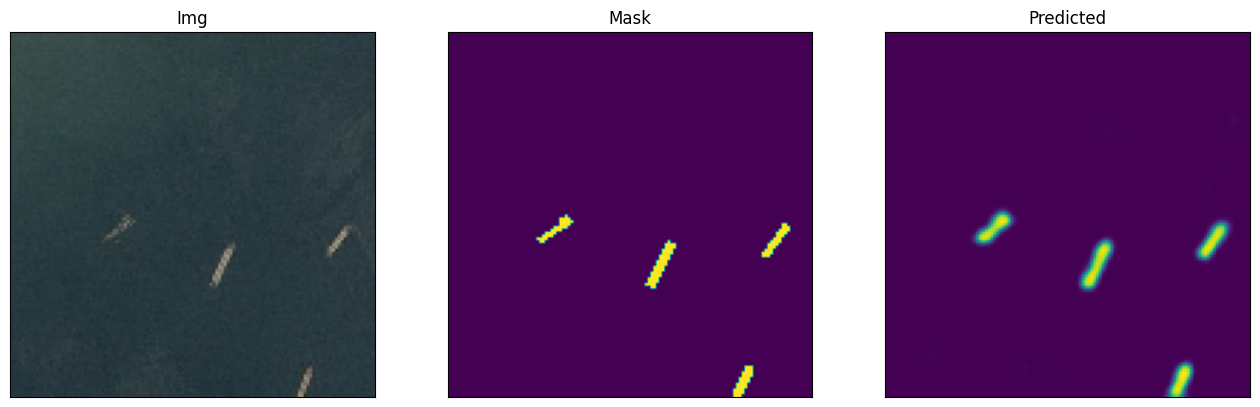

In [209]:
test_image = 2000


visualize(img = x_test_numpy[test_image], mask = y_test_numpy[test_image], predicted = segmentation_model.predict(x_test_numpy[test_image].reshape(1, 128, 128, 3))[0])

Resulting model shows great results in ship designation on seas while requiring little to no training and time to run, however Dice score shows possible improvement of the model, that might be done by altering dataset to include more marked ships

In [211]:
best_model = keras.saving.load_model("best_model.keras")

In [212]:
best_model.evaluate(x_test_numpy, y_test_numpy)

130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - binary_accuracy: 0.9975 - binary_io_u_15: 0.7810 - loss: 0.0075


[0.00750376470386982, 0.7800995111465454, 0.9974788427352905]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


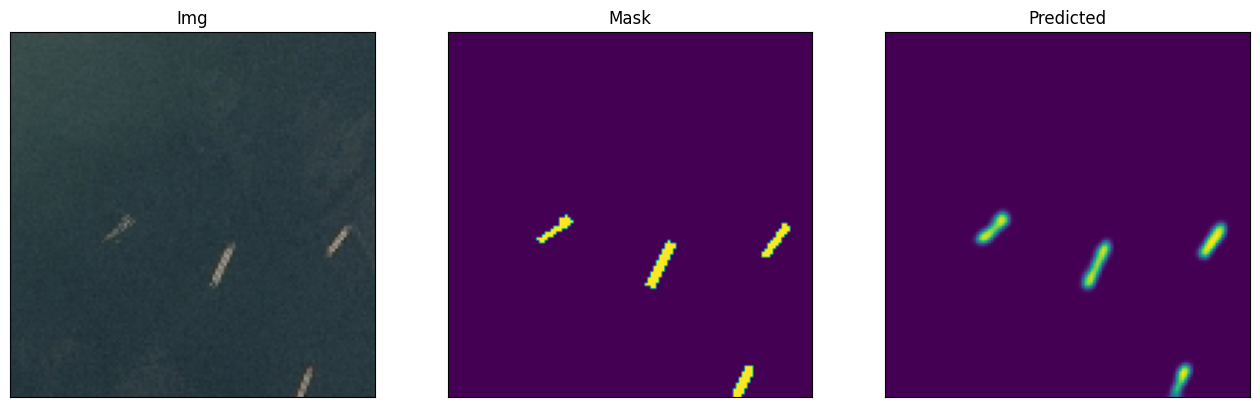

In [224]:
test_image = 2000


visualize(img = x_test_numpy[test_image], mask = y_test_numpy[test_image], predicted = best_model.predict(x_test_numpy[test_image].reshape(1, 128, 128, 3))[0])

In [225]:
grid_predicted = best_model.predict(x_test_numpy[test_image : test_image + 15])
grid_predicted.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


(15, 128, 128, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


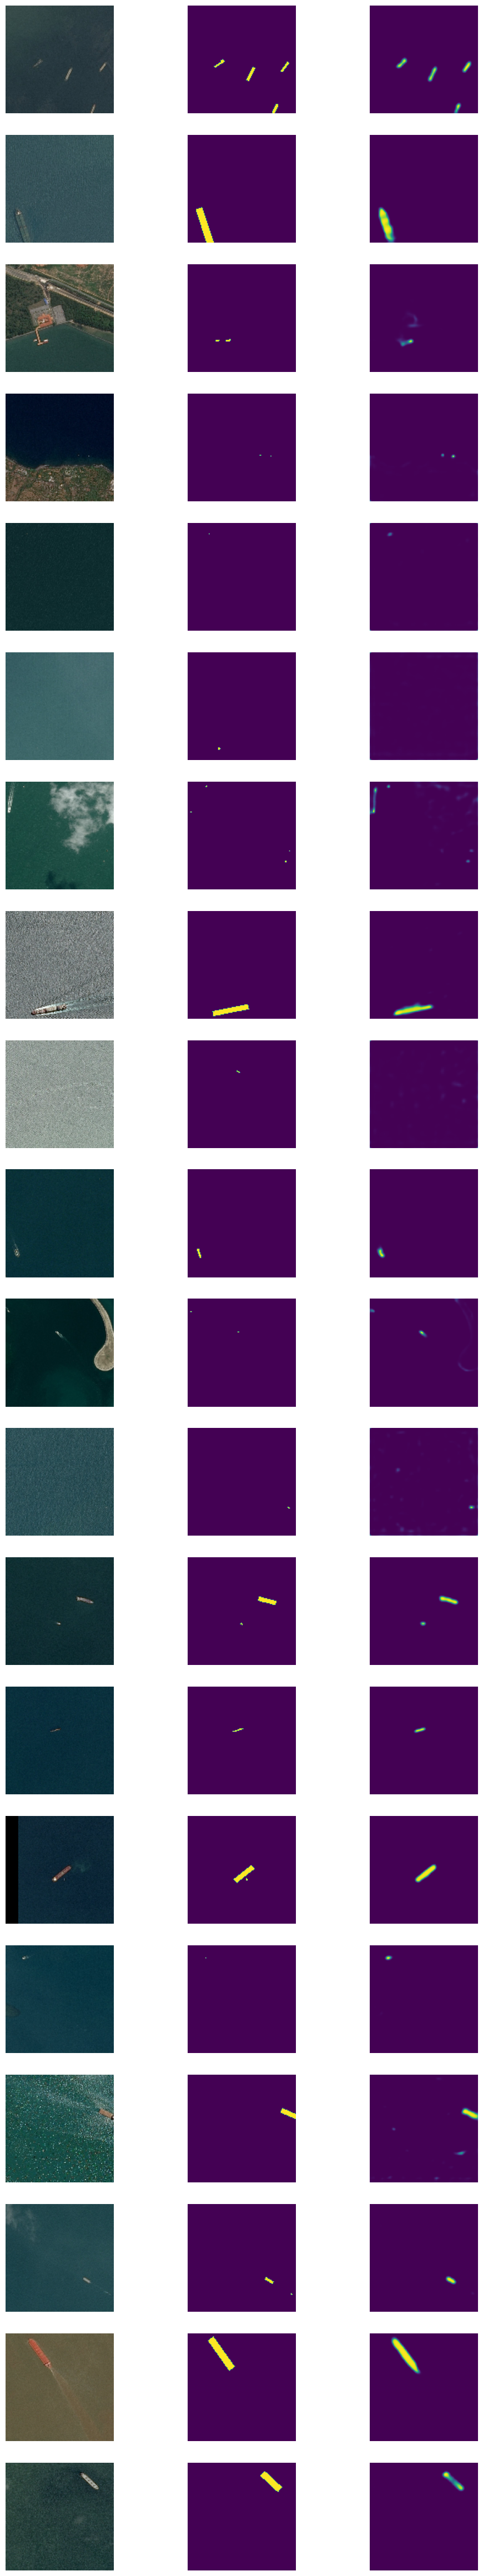

In [237]:
slice_num = 2000
slice_amount = 20

visualize_multiple_rows(
    x_test_numpy[slice_num : slice_num + slice_amount],
    y_test_numpy[slice_num : slice_num + slice_amount],
    best_model.predict(x_test_numpy[slice_num : slice_num + slice_amount]),
)